In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from pathlib import Path
from tqdm.notebook import tqdm

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function to load the processed parquet files
def load_processed_data(n_files=None):
    """
    Load processed parquet files
    
    Parameters:
    n_files (int): Number of files to load, if None, load all files
    
    Returns:
    pandas.DataFrame: Combined dataframe from all loaded files
    """
    processed_path = Path('processed_chunks')
    files = list(processed_path.glob('*.parquet'))
    
    if n_files:
        files = files[:n_files]  # Load only specified number of files for testing
    
    print(f"Loading {len(files)} parquet files...")
    
    # Use list comprehension with tqdm for progress tracking
    dfs = [pd.read_parquet(file) for file in tqdm(files)]
    
    if not dfs:
        raise ValueError("No data files found or loaded")
    
    # Combine all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

# Load merchant reference data
def load_merchant_reference():
    """
    Load merchant reference data
    
    Returns:
    pandas.DataFrame: Merchant reference dataframe
    """
    try:
        merchants_ref = pd.read_csv('transaction_data/reference/merchants_reference.csv')
        return merchants_ref
    except Exception as e:
        print(f"Error loading merchant reference data: {e}")
        return None

sample_data = load_processed_data(n_files=7)  
print(f"Sample data shape: {sample_data.shape}")

# Display sample data
sample_data.head()


Loading 7 parquet files...


  0%|          | 0/7 [00:00<?, ?it/s]

Sample data shape: (11959500, 21)


,transaction_id,timestamp,user_id,merchant_id,merchant_name,merchant_category,amount,currency,location_country,location_city,...,device_type,status,missing_amount,is_amount_outlier,day_of_week,is_weekend,hour,time_period,days_since_transaction,high_value_online
0,7d40ea78-796a-4e07-92b5-543fc2d41375,2025-04-07,USER00056168,MERCH000620,money bank,Financial,40.549999,GBP,Brazil,Fortaleza,...,Mobile,completed,False,False,0,False,0,night,35,False
1,d6eca232-ce52-48a0-b6c7-bf5aa52e9f98,2025-04-07,USER00082086,MERCH000080,finance credit,Financial,10.000000,EUR,Australia,Perth,...,unknown,completed,False,False,0,False,0,night,35,False
2,e597fe74-f98b-4927-be38-7b1db748a5d4,2025-04-07,USER00094393,MERCH000156,city mart,Retail,57.900002,JPY,Mexico,Tijuana,...,unknown,pending,False,False,0,False,0,night,35,False
3,e9df9a90-1e85-4450-9137-17788957e714,2025-04-07,USER00046636,MERCH000515,health center,Healthcare,25.260000,EUR,Australia,Sydney,...,unknown,completed,False,False,0,False,0,night,35,False
4,2e5fe087-2a5d-49ed-99b0-cb8e330d3304,2025-04-07,USER00087000,MERCH000501,utility services,Utilities,106.010002,GBP,Canada,Ottawa,...,unknown,completed,False,False,0,False,0,night,35,False


In [3]:
def explore_data(df):
    """
    Perform basic exploration of the dataset
    """
    print(f"Dataset shape: {df.shape}")
    print("\nData types:")
    print(df.dtypes)
    print("\nMissing values:")
    print(df.isnull().sum())
    print("\nSummary statistics:")
    print(df.describe(include='all').T)

In [4]:
# Data preprocessing and feature engineering
def preprocess_data(df):
    """
    Preprocess and engineer features for modeling
    
    Parameters:
    df (pandas.DataFrame): Input dataframe
    
    Returns:
    pandas.DataFrame: Processed dataframe with engineered features
    """
    # Make a copy to avoid modifying the original
    processed_df = df.copy()
    
    # Convert timestamp to datetime
    processed_df['timestamp'] = pd.to_datetime(processed_df['timestamp'])
    
    # Extract datetime features
    processed_df['hour'] = processed_df['timestamp'].dt.hour
    processed_df['day_of_week'] = processed_df['timestamp'].dt.dayofweek
    processed_df['day_of_month'] = processed_df['timestamp'].dt.day
    processed_df['month'] = processed_df['timestamp'].dt.month
    processed_df['year'] = processed_df['timestamp'].dt.year
    
    # Create weekend flag
    processed_df['is_weekend'] = processed_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Create time-of-day category
    bins = [0, 6, 12, 18, 24]
    labels = ['Night', 'Morning', 'Afternoon', 'Evening']
    processed_df['time_of_day'] = pd.cut(processed_df['hour'], bins=bins, labels=labels, include_lowest=True)
    
    # Convert boolean to integer
    if 'is_online' in processed_df.columns:
        processed_df['is_online'] = processed_df['is_online'].astype(int)
    
    return processed_df

In [5]:
# Aggregate user data for clustering
def aggregate_user_data(df, sample_size=None):
    """
    Aggregate transaction data to user level for clustering
    
    Parameters:
    df (pandas.DataFrame): Input transaction dataframe
    sample_size (int): Optional sample size for large datasets
    
    Returns:
    pandas.DataFrame: User-level aggregated dataframe
    """
    # Take a sample if specified (for memory efficiency with large datasets)
    if sample_size and len(df) > sample_size:
        df = df.sample(sample_size, random_state=42)
    
    print("Aggregating transaction data to user level...")
    
    # Group by user_id and compute aggregations
    user_features = df.groupby('user_id').agg({
        'transaction_id': 'count',
        'amount': ['mean', 'std', 'min', 'max', 'sum'],
        'is_online': 'mean',
        'is_weekend': 'mean',
        'merchant_id': 'nunique',
        'merchant_category': 'nunique',
        'location_country': 'nunique',
        'device_type': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'hour': ['mean', 'std'],
        'day_of_week': 'mean'
    }).reset_index()
    
    # Flatten multi-level column names
    user_features.columns = ['_'.join(col).strip('_') for col in user_features.columns.values]
    
    # Rename columns for clarity
    user_features = user_features.rename(columns={
        'transaction_id_count': 'transaction_count',
        'amount_mean': 'avg_transaction_amount',
        'amount_std': 'std_transaction_amount',
        'amount_min': 'min_transaction_amount',
        'amount_max': 'max_transaction_amount',
        'amount_sum': 'total_spend',
        'is_online_mean': 'online_transaction_ratio',
        'is_weekend_mean': 'weekend_transaction_ratio',
        'merchant_id_nunique': 'unique_merchants',
        'merchant_category_nunique': 'unique_categories',
        'location_country_nunique': 'unique_countries',
        'device_type_<lambda>': 'preferred_device',
        'hour_mean': 'avg_transaction_hour',
        'hour_std': 'std_transaction_hour',
        'day_of_week_mean': 'avg_day_of_week'
    })
    
    # Add transaction frequency features (transactions per day)
    if 'timestamp' in df.columns:
        user_date_counts = df.groupby(['user_id', df['timestamp'].dt.date]).size().reset_index()
        user_date_counts.columns = ['user_id', 'date', 'daily_transactions']
        
        # Calculate average transactions per active day and active days
        user_activity = user_date_counts.groupby('user_id').agg({
            'daily_transactions': 'mean',
            'date': 'nunique'
        }).reset_index()
        
        user_activity.columns = ['user_id', 'avg_daily_transactions', 'active_days']
        
        # Merge with user features
        user_features = user_features.merge(user_activity, on='user_id', how='left')
    
    # Handle missing values
    numeric_cols = user_features.select_dtypes(include=['float64', 'int64']).columns
    user_features[numeric_cols] = user_features[numeric_cols].fillna(0)
    
    return user_features

# Apply preprocessing to sample data
print("Preprocessing sample data...")
processed_data = preprocess_data(sample_data)

Preprocessing sample data...


In [7]:
def determine_optimal_clusters(data, max_clusters=10):
    """
    Determine the optimal number of clusters using the Elbow Method
    
    Parameters:
    data (numpy.ndarray): Feature matrix for clustering
    max_clusters (int): Maximum number of clusters to consider
    
    Returns:
    tuple: Inertia values for each k, suggested optimal k
    """
    print("Finding optimal number of clusters...")
    
    # Check for NaN values and handle them
    if np.isnan(data).any():
        print("Warning: Input data contains NaN values. Imputing with column means...")
        # Simple imputation with column means
        col_means = np.nanmean(data, axis=0)
        mask = np.isnan(data)
        data = data.copy()  # Create a copy to avoid modifying the original
        for i in range(data.shape[1]):
            data[:, i][mask[:, i]] = col_means[i]
    
    inertia_values = []
    k_values = range(2, max_clusters + 1)
    
    for k in k_values:
        # Use MiniBatchKMeans for memory efficiency
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)
    
    # Calculate changes in inertia to find "elbow" point
    inertia_changes = np.diff(inertia_values)
    inertia_changes_ratio = np.diff(inertia_changes) / inertia_changes[:-1]
    
    # Find the elbow point (where the rate of change flattens)
    optimal_k = k_values[np.argmax(inertia_changes_ratio) + 1] if len(inertia_changes_ratio) > 0 else k_values[0]
    
    return inertia_values, optimal_k

In [8]:
def apply_clustering(df, n_clusters=4):
    """
    Apply K-means clustering to user data
    
    Parameters:
    df (pandas.DataFrame): User-level features dataframe
    n_clusters (int): Number of clusters
    
    Returns:
    pandas.DataFrame: Dataframe with cluster assignments
    sklearn.cluster.KMeans: Fitted KMeans model
    numpy.ndarray: Scaled feature matrix
    """
    print(f"Applying K-means clustering with {n_clusters} clusters...")
    
    # Select numerical features for clustering
    feature_cols = [col for col in df.columns if col != 'user_id' and col != 'preferred_device']
    
    # Check for NaN values
    if df[feature_cols].isnull().values.any():
        print("Handling missing values before clustering...")
        
        # Create a copy to avoid modifying the original
        df_imputed = df.copy()
        
        # Impute missing values - most robust approach is median for numeric features
        imputer = SimpleImputer(strategy='median')
        df_imputed[feature_cols] = imputer.fit_transform(df[feature_cols])
        
        # Use the imputed dataframe for standardization
        X = StandardScaler().fit_transform(df_imputed[feature_cols])
    else:
        # If no missing values, proceed as normal
        X = StandardScaler().fit_transform(df[feature_cols])
    
    # Apply K-means clustering
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000)
    df['cluster'] = kmeans.fit_predict(X)
    
    return df, kmeans, X

In [9]:
def analyze_clusters(df, feature_cols):
    """
    Analyze and visualize cluster characteristics
    
    Parameters:
    df (pandas.DataFrame): Dataframe with cluster assignments
    feature_cols (list): List of feature column names
    """
    print("Analyzing clusters...")
    
    # Calculate cluster statistics
    cluster_stats = df.groupby('cluster')[feature_cols].mean()
    print("\nCluster centers (mean values):")
    print(cluster_stats)
    
    # Cluster sizes
    cluster_sizes = df['cluster'].value_counts().sort_index()
    print("\nCluster sizes:")
    print(cluster_sizes)
    
    # Visualize cluster sizes
    plt.figure(figsize=(10, 6))
    sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values)
    plt.title('Cluster Sizes')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Users')
    plt.show()
    
    # Visualize key features across clusters
    for feature in feature_cols[:5]:  # Show top 5 features
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='cluster', y=feature, data=df)
        plt.title(f'{feature} by Cluster')
        plt.xlabel('Cluster')
        plt.show()
    
    # Check for NaN values before PCA
    if df[feature_cols].isnull().values.any():
        print("Handling missing values before PCA visualization...")
        # Create a copy of the data for PCA
        df_pca = df.copy()
        
        # Impute missing values with median for PCA
        imputer = SimpleImputer(strategy='median')
        df_pca[feature_cols] = imputer.fit_transform(df[feature_cols])
        
        # Now run PCA on the cleaned data
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(df_pca[feature_cols])
    else:
        # If no missing values, proceed as normal
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(df[feature_cols])
    
    # Create visualization dataframe
    viz_df = pd.DataFrame({
        'PC1': X_pca[:, 0],
        'PC2': X_pca[:, 1],
        'Cluster': df['cluster']
    })
    
    # Plot PCA results
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=viz_df, palette='viridis', alpha=0.6)
    plt.title('PCA Visualization of User Clusters')
    plt.show()
    
    # Radar chart for cluster profiles
    cluster_profile = cluster_stats.copy()
    
    # Normalize data for radar chart
    for col in cluster_profile.columns:
        cluster_profile[col] = (cluster_profile[col] - cluster_profile[col].min()) / (cluster_profile[col].max() - cluster_profile[col].min())
    
    # Select a subset of features for clarity
    selected_features = feature_cols[:6]  # Using first 6 features
    
    # Calculate layout for radar charts
    num_clusters = len(cluster_profile)
    rows = int(np.ceil(np.sqrt(num_clusters)))
    cols = int(np.ceil(num_clusters / rows))
    
    # Create radar chart with dynamic layout
    fig = plt.figure(figsize=(15, 10))
    
    for i in range(len(cluster_profile)):
        values = cluster_profile.iloc[i][selected_features].tolist()
        values += values[:1]  # Close the loop
        
        ax = fig.add_subplot(rows, cols, i+1, polar=True)
        angles = np.linspace(0, 2*np.pi, len(selected_features), endpoint=False).tolist()
        angles += angles[:1]  # Close the loop
        
        ax.plot(angles, values)
        ax.fill(angles, values, alpha=0.1)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(selected_features)
        ax.set_title(f'Cluster {i} Profile')
    
    plt.tight_layout()
    plt.show()

Aggregating transaction data to user level...
Missing values in clustering features:
std_transaction_amount    30154
dtype: int64
Finding optimal number of clusters...


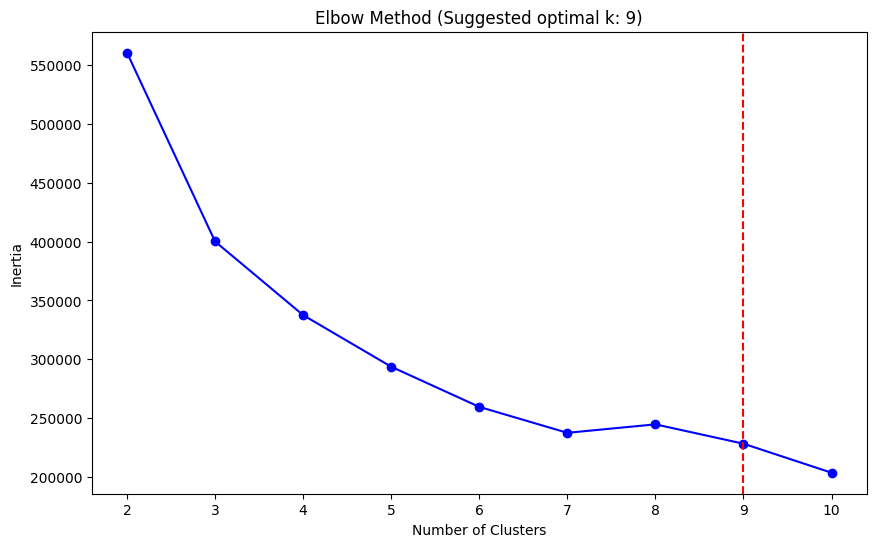

Applying K-means clustering with 9 clusters...
Handling missing values before clustering...
Analyzing clusters...

Cluster centers (mean values):
         transaction_count  avg_transaction_amount  std_transaction_amount  \
cluster                                                                      
0                 1.000000               48.451195                     NaN   
1                 2.000442               56.332005               44.360653   
2                 1.000389               53.285629                7.170063   
3                 1.000000               35.081928                     NaN   
4                 1.000000               50.746346                     NaN   
5                 2.466448               65.830261               57.808563   
6                 1.140969              514.019592              577.416748   
7                 1.000000               75.369514                     NaN   
8                 2.070028               63.050499               52.290676

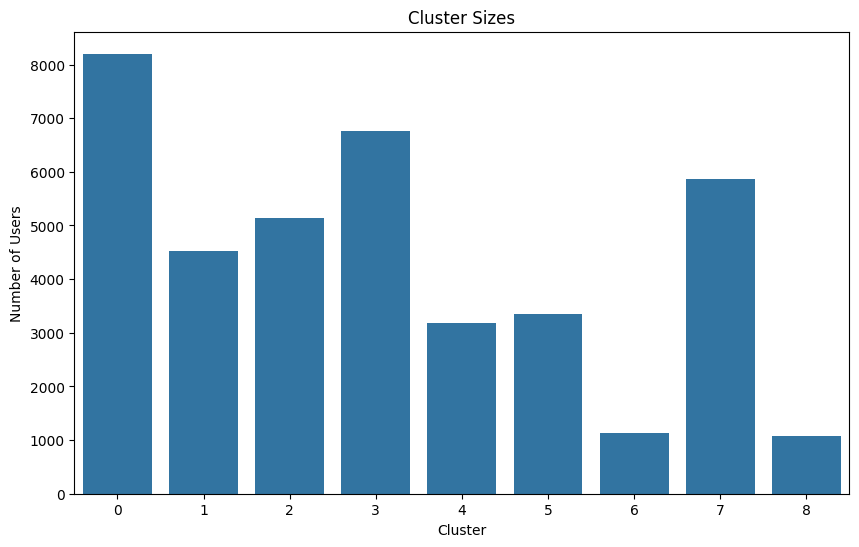

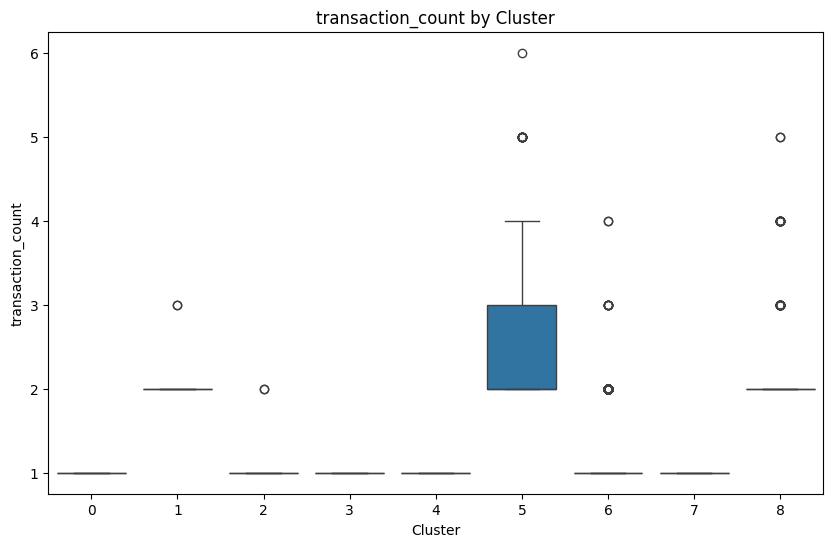

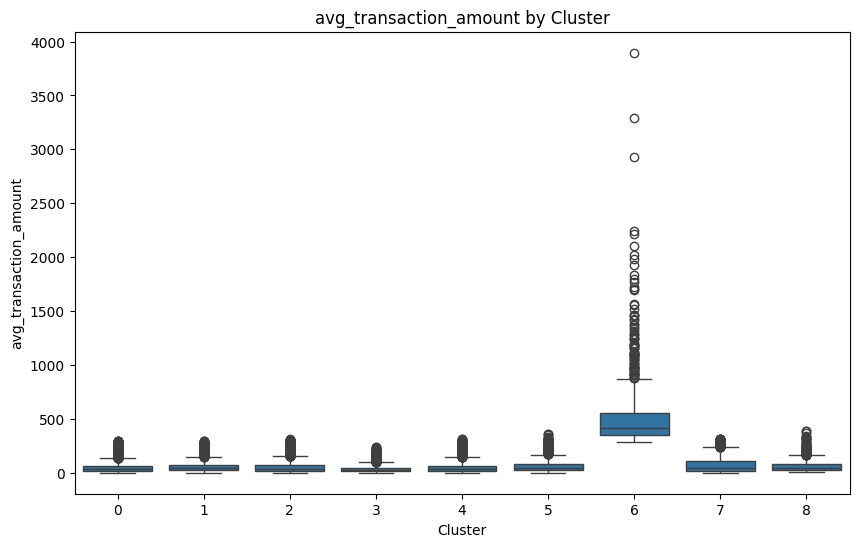

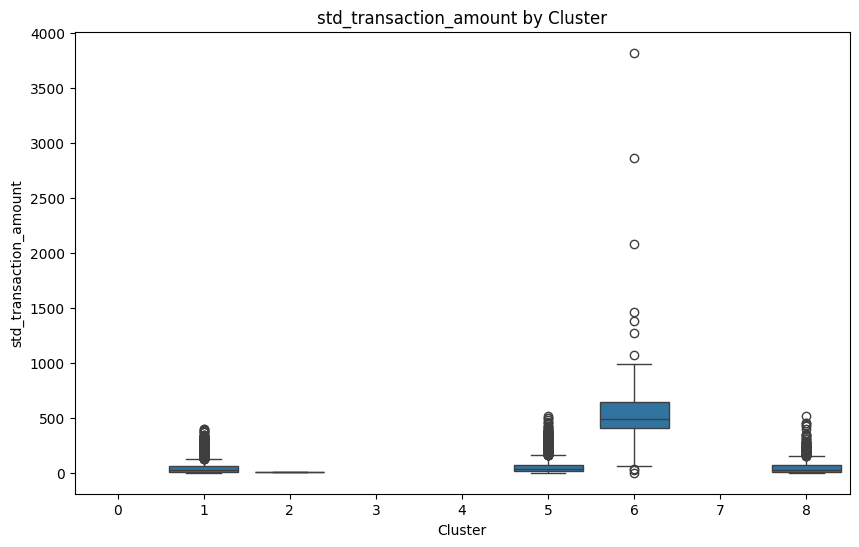

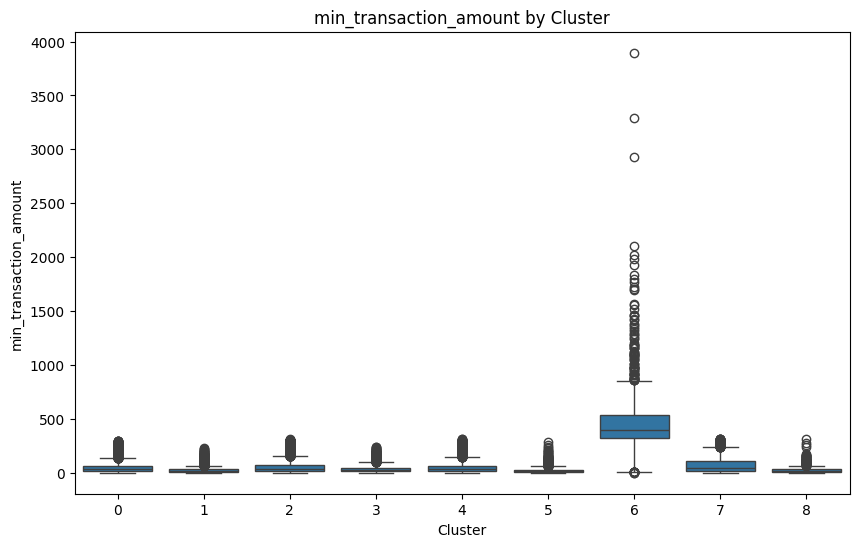

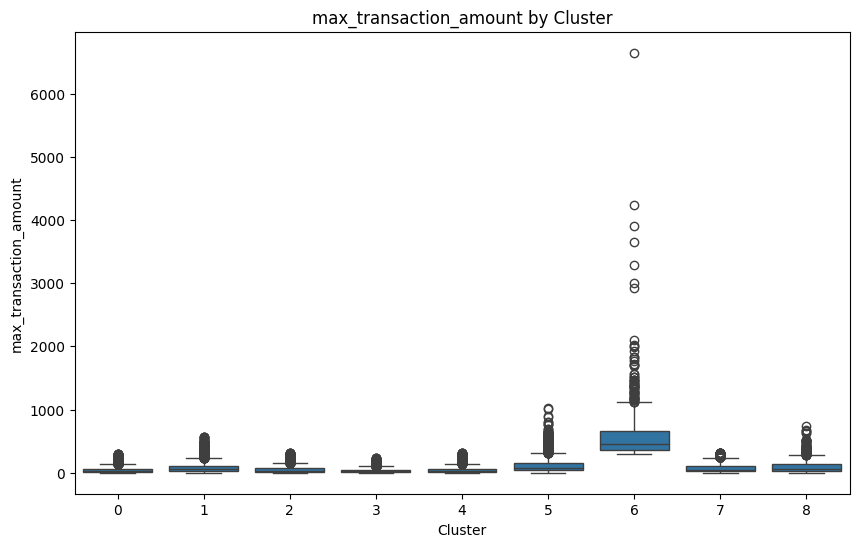

Handling missing values before PCA visualization...


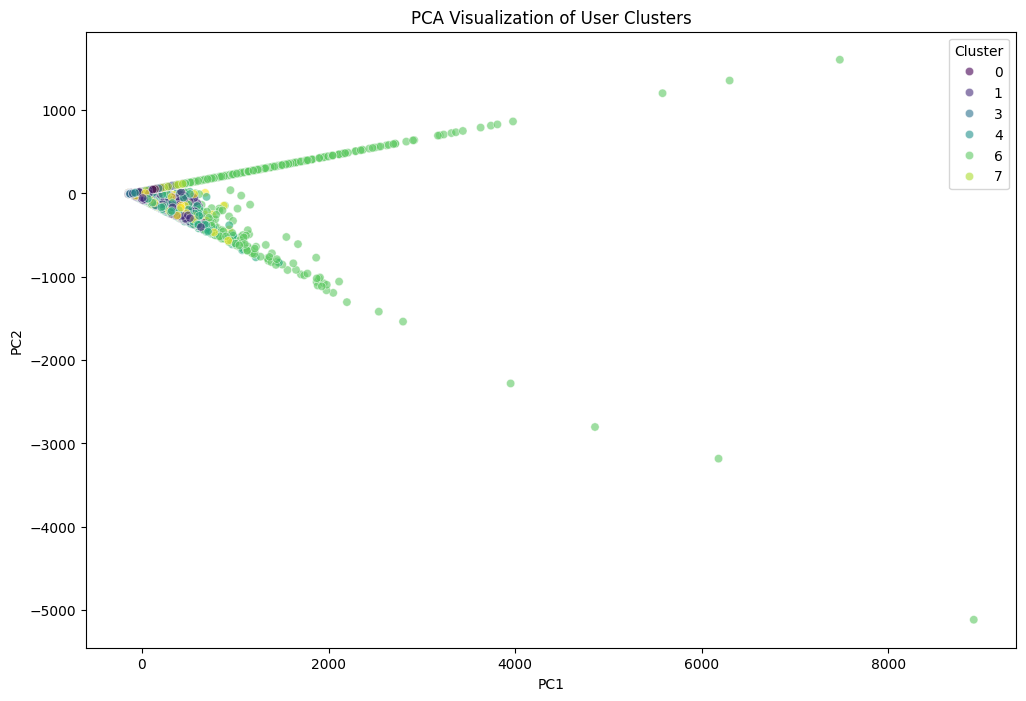

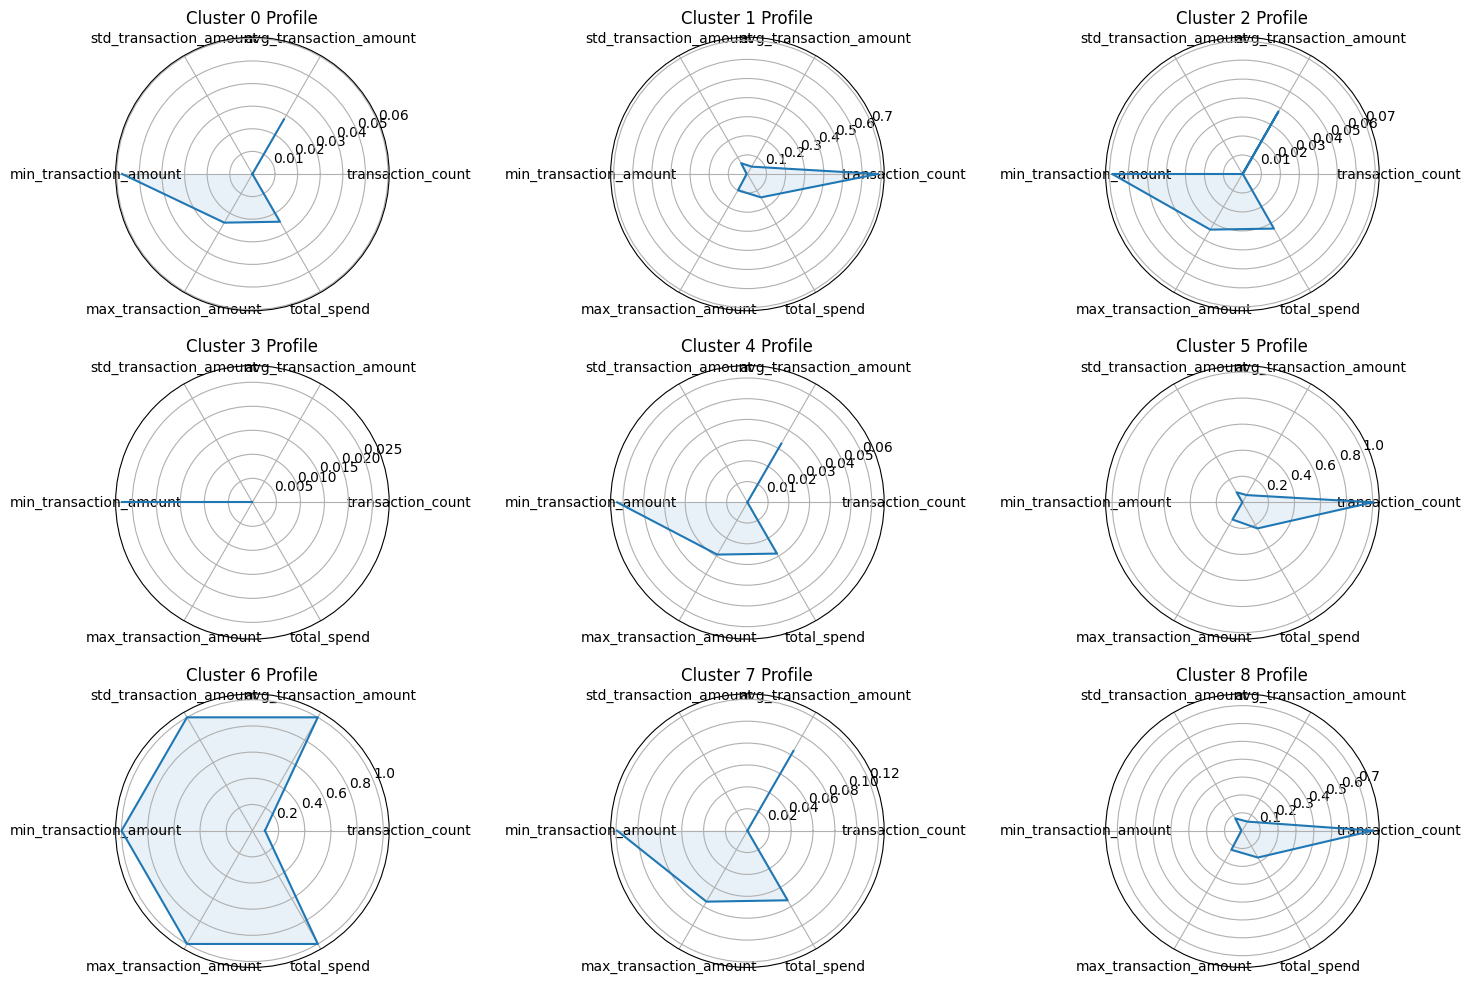

In [10]:
# Execute user segmentation
# First, aggregate to user level
user_data = aggregate_user_data(processed_data, sample_size=50000)  # Using a sample for memory efficiency

# Select features for clustering
cluster_features = [col for col in user_data.columns if col != 'user_id' and col != 'preferred_device']

# Check for and report any missing values
missing_values = user_data[cluster_features].isnull().sum()
if missing_values.sum() > 0:
    print("Missing values in clustering features:")
    print(missing_values[missing_values > 0])
    
    # Handle missing values before standardization
    imputer = SimpleImputer(strategy='median')
    user_data_imputed = user_data.copy()
    user_data_imputed[cluster_features] = imputer.fit_transform(user_data[cluster_features])
    
    # Now standardize the imputed data
    X_cluster = StandardScaler().fit_transform(user_data_imputed[cluster_features])
else:
    # If no missing values, proceed as normal
    X_cluster = StandardScaler().fit_transform(user_data[cluster_features])

# Find optimal number of clusters
inertia, optimal_k = determine_optimal_clusters(X_cluster, max_clusters=10)

# Visualize the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(2, len(inertia) + 2), inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title(f'Elbow Method (Suggested optimal k: {optimal_k})')
plt.axvline(x=optimal_k, color='r', linestyle='--')
plt.show()

# Apply clustering with optimal k
clustered_users, kmeans_model, X_scaled = apply_clustering(user_data, n_clusters=optimal_k)

# Analyze and visualize clusters
analyze_clusters(clustered_users, cluster_features)

In [11]:
# Transaction value prediction with linear regression
def prepare_prediction_features(df, target='amount'):
    """
    Prepare features for transaction value prediction
    
    Parameters:
    df (pandas.DataFrame): Input dataframe
    target (str): Target column name
    
    Returns:
    tuple: X (features), y (target), categorical_cols, numerical_cols
    """
    print("Preparing features for transaction value prediction...")
    
    # Remove rows with missing target values
    df = df.dropna(subset=[target])
    
    # Define feature sets
    categorical_cols = ['merchant_category', 'currency', 'location_country', 
                       'device_type', 'time_of_day', 'is_online']
    
    numerical_cols = ['hour', 'day_of_week', 'day_of_month', 'month', 'year', 
                      'is_weekend']
    
    # Add user-level aggregated features if available
    if 'user_transaction_count' in df.columns:
        numerical_cols.extend(['user_transaction_count', 'user_avg_amount'])
    
    # Ensure all categorical columns are of string type
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype(str)
    
    # Extract features and target
    X = df[categorical_cols + numerical_cols]
    y = df[target]
    
    return X, y, categorical_cols, numerical_cols

In [12]:
def build_regression_model(X, y, categorical_cols, numerical_cols, test_size=0.2):
    """
    Build and evaluate a regression model for transaction value prediction
    
    Parameters:
    X (pandas.DataFrame): Features
    y (pandas.Series): Target
    categorical_cols (list): Categorical feature names
    numerical_cols (list): Numerical feature names
    test_size (float): Test set proportion
    
    Returns:
    tuple: Trained model, feature names, X_test, y_test, y_pred
    """
    print("Building regression model...")
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Create preprocessing pipelines for numeric and categorical data
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    # Create the modeling pipeline
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=1.0))  # Using Ridge regression for better stability
    ])
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions on test set
    y_pred = model.predict(X_test)
    
    # Get feature names after one-hot encoding
    cat_feature_names = []
    if model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out is not None:
        cat_feature_names = list(model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out())
    feature_names = numerical_cols + cat_feature_names
    
    return model, feature_names, X_test, y_test, y_pred


In [13]:
def evaluate_regression_model(y_test, y_pred):
    """
    Evaluate regression model performance
    
    Parameters:
    y_test (pandas.Series): True values
    y_pred (numpy.ndarray): Predicted values
    
    Returns:
    dict: Dictionary of evaluation metrics
    """
    print("Evaluating regression model...")
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print metrics
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    
    # Create histogram of residuals
    residuals = y_test - y_pred
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred, y_test, alpha=0.5)
    plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], 'r--')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Actual vs Predicted Values')
    
    plt.subplot(1, 2, 2)
    plt.hist(residuals, bins=30, alpha=0.7)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residuals Distribution')
    plt.tight_layout()
    plt.show()
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

In [14]:
def analyze_feature_importance(model, feature_names):
    """
    Analyze feature importance from the regression model
    
    Parameters:
    model: Trained regression model
    feature_names (list): Feature names
    """
    print("Analyzing feature importance...")
    
    # Extract coefficients
    if hasattr(model.named_steps['regressor'], 'coef_'):
        coefficients = model.named_steps['regressor'].coef_
        
        # Create DataFrame of feature importance
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': np.abs(coefficients)
        })
        
        # Sort by importance
        feature_importance = feature_importance.sort_values('Importance', ascending=False)
        
        # Display top 20 features
        top_features = feature_importance.head(20)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title('Top 20 Feature Importance')
        plt.tight_layout()
        plt.show()
        
        return feature_importance
    else:
        print("Model doesn't support feature importance extraction")
        return None

In [15]:
def enrich_with_user_features(df, clustered_users):
    """
    Enrich transaction data with user-level features
    
    Parameters:
    df (pandas.DataFrame): Transaction data
    clustered_users (pandas.DataFrame): User-level data with clusters
    
    Returns:
    pandas.DataFrame: Enriched dataframe
    """
    print("Enriching transactions with user-level features...")
    
    # Calculate user stats
    user_stats = df.groupby('user_id').agg({
        'transaction_id': 'count',
        'amount': 'mean'
    }).reset_index()
    
    user_stats.columns = ['user_id', 'user_transaction_count', 'user_avg_amount']
    
    # Merge with transaction data
    enriched_df = df.merge(user_stats, on='user_id', how='left')
    
    # Add cluster assignment if available
    if 'cluster' in clustered_users.columns:
        user_clusters = clustered_users[['user_id', 'cluster']]
        enriched_df = enriched_df.merge(user_clusters, on='user_id', how='left')
        enriched_df['cluster'] = enriched_df['cluster'].fillna(-1).astype(int)
    
    return enriched_df

Enriching transactions with user-level features...
Preparing features for transaction value prediction...
Building regression model...
Evaluating regression model...
RMSE: 121.78
MAE: 61.36
R²: 0.0083


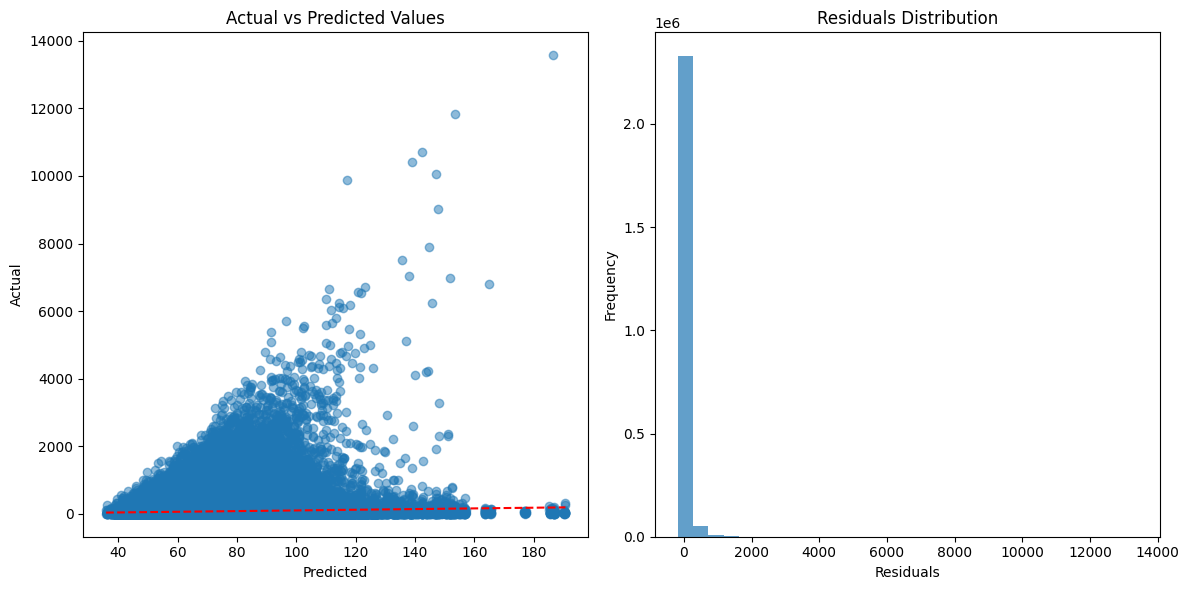

Analyzing feature importance...


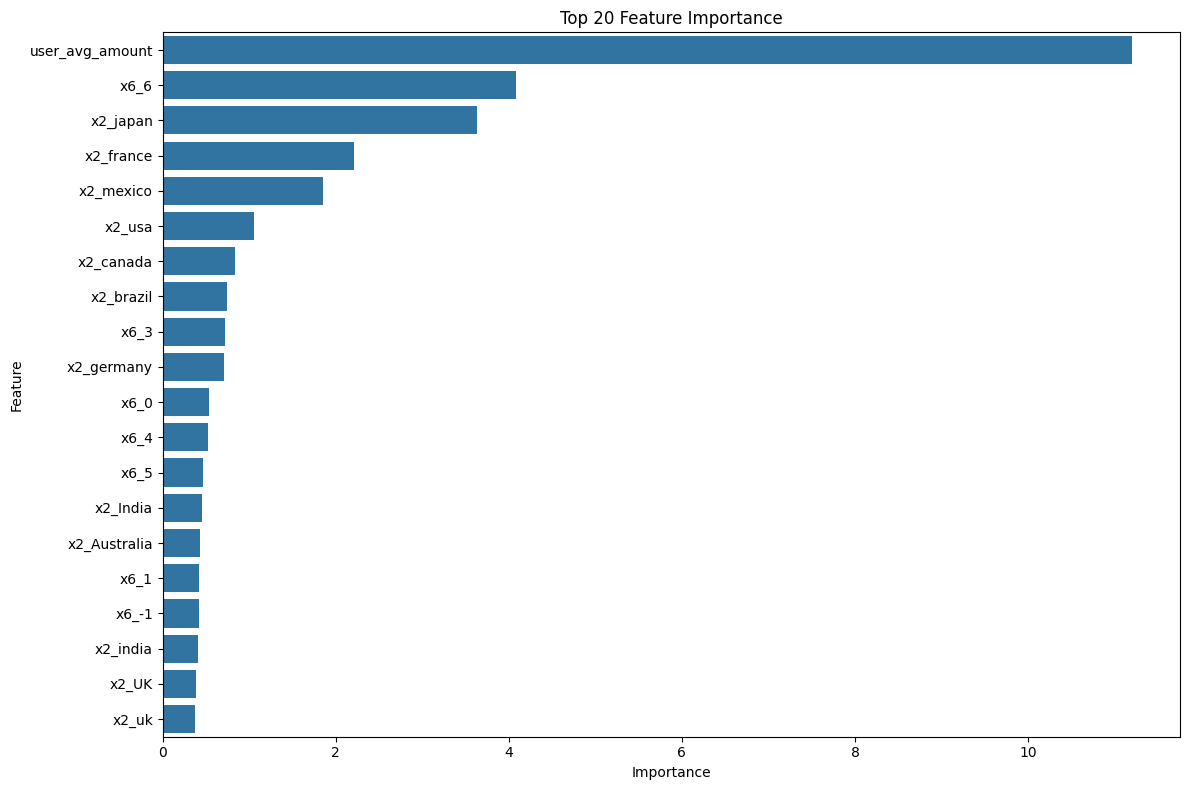

In [16]:
# Execute transaction value prediction
# Enrich data with user features for better prediction
enriched_data = enrich_with_user_features(processed_data, clustered_users)

# Prepare features for prediction
X, y, cat_cols, num_cols = prepare_prediction_features(enriched_data, target='amount')

# Add cluster as a feature if available
if 'cluster' in enriched_data.columns:
    X['cluster'] = enriched_data['cluster']
    cat_cols.append('cluster')

# Build and evaluate the model
reg_model, feature_names, X_test, y_test, y_pred = build_regression_model(X, y, cat_cols, num_cols)

# Evaluate the model
metrics = evaluate_regression_model(y_test, y_pred)

# Analyze feature importance
feature_importance = analyze_feature_importance(reg_model, feature_names)

In [18]:
def generate_business_insights(clustered_users, regression_metrics, feature_importance):
    """
    Generate business insights and recommendations based on clustering and regression results
    """
    print("\n==== BUSINESS INSIGHTS AND RECOMMENDATIONS ====\n")
    
    # 1. Cluster-based user segmentation insights
    print("1. User Segmentation Insights:")
    cluster_counts = clustered_users['cluster'].value_counts()
    for cluster in cluster_counts.index:
        cluster_size = cluster_counts[cluster]
        cluster_pct = 100 * cluster_size / len(clustered_users)
        
        # Get key characteristics of this cluster
        cluster_data = clustered_users[clustered_users['cluster'] == cluster]
        
        # Calculate mean values for key metrics
        avg_tx_count = cluster_data['transaction_count'].mean()
        avg_tx_amount = cluster_data['avg_transaction_amount'].mean()
        total_spend = cluster_data['total_spend'].mean()
        online_ratio = cluster_data['online_transaction_ratio'].mean()
        
        print(f"\nCluster {cluster} ({cluster_size} users, {cluster_pct:.1f}%):")
        print(f"- Avg. transactions per user: {avg_tx_count:.1f}")
        print(f"- Avg. transaction amount: ${avg_tx_amount:.2f}")
        print(f"- Avg. total spend per user: ${total_spend:.2f}")
        print(f"- Online transaction ratio: {online_ratio:.2f}")
        
        # Generate insights based on cluster characteristics
        if avg_tx_amount > clustered_users['avg_transaction_amount'].mean():
            print("  → High-value segment")
        if avg_tx_count > clustered_users['transaction_count'].mean():
            print("  → Frequent buyers")
        if online_ratio > 0.7:
            print("  → Primarily online shoppers")
        elif online_ratio < 0.3:
            print("  → Primarily in-store shoppers")
    
    # 2. Transaction prediction insights
    print("\n2. Transaction Value Prediction Insights:")
    print(f"- Model performance: R² = {regression_metrics['r2']:.4f}, RMSE = ${regression_metrics['rmse']:.2f}")
    
    # Top predictors
    if feature_importance is not None:
        top_predictors = feature_importance.head(5)
        print(f"- Top predictors of transaction value:")
        for i, row in top_predictors.iterrows():
            print(f"  · {row['Feature']}")
    
    # 3. Business Recommendations
    print("\n3. Business Recommendations:")
    
    print("""
    Based on the user segmentation and transaction prediction models:
    
    a) Personalized Marketing Strategies:
       - Develop targeted campaigns for each user cluster
       - Focus retention efforts on high-value segments
       - Create re-engagement campaigns for occasional shoppers
    
    b) Product Recommendations:
       - Use cluster profiles to guide personalized product recommendations
       - Focus cross-selling efforts based on segment preferences
    
    c) User Experience Optimization:
       - Optimize digital experience for clusters with high online transaction ratios
       - Improve in-store experience for predominantly offline clusters
    
    d) Fraud Detection:
       - Use transaction value predictions to flag unusual transaction amounts
       - Incorporate user clusters into risk scoring models
    
    e) Resource Allocation:
       - Allocate marketing budget proportional to cluster value and growth potential
       - Focus customer service resources on high-value segments
    """)
    
    # 4. Implementation strategy
    print("\n4. Implementation Strategy:")
    print("""
    To implement these insights in a production environment:
    
    a) Infrastructure:
       - Deploy models through a real-time API service
       - Develop batch processing pipeline for regular user segmentation updates
       - Create dashboards to monitor segment KPIs
    
    b) Testing Plan:
       - Run A/B tests for marketing campaigns by segment
       - Measure lift in conversion rates and revenue
       - Continuously validate prediction model accuracy
    
    c) Enhancement Roadmap:
       - Add additional data sources (e.g., product categories, customer support interactions)
       - Implement deep learning models for improved prediction accuracy
       - Develop real-time personalization capabilities
    """)

# Execute business insights generation
generate_business_insights(clustered_users, metrics, feature_importance)


==== BUSINESS INSIGHTS AND RECOMMENDATIONS ====

1. User Segmentation Insights:

Cluster 0 (8202 users, 20.9%):
- Avg. transactions per user: 1.0
- Avg. transaction amount: $48.45
- Avg. total spend per user: $48.45
- Online transaction ratio: 1.00
  → Primarily online shoppers

Cluster 3 (6759 users, 17.2%):
- Avg. transactions per user: 1.0
- Avg. transaction amount: $35.08
- Avg. total spend per user: $35.08
- Online transaction ratio: 0.00
  → Primarily in-store shoppers

Cluster 7 (5876 users, 15.0%):
- Avg. transactions per user: 1.0
- Avg. transaction amount: $75.37
- Avg. total spend per user: $75.37
- Online transaction ratio: 0.01
  → High-value segment
  → Primarily in-store shoppers

Cluster 2 (5145 users, 13.1%):
- Avg. transactions per user: 1.0
- Avg. transaction amount: $53.29
- Avg. total spend per user: $53.30
- Online transaction ratio: 0.57

Cluster 1 (4522 users, 11.5%):
- Avg. transactions per user: 2.0
- Avg. transaction amount: $56.33
- Avg. total spend per use

In [47]:
import os
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate
from langchain.schema import StrOutputParser
from dotenv import load_dotenv
import pandas as pd
import json
from datetime import datetime

In [48]:
load_dotenv()

# Configure with API key from environment variables
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

# If no API key is found, provide guidance
if not GROQ_API_KEY:
    raise ValueError(
        "GROQ_API_KEY not found in environment variables. "
        "Please add it to your .env file: GROQ_API_KEY=your_api_key_here"
    )

In [49]:
def generate_llm_insights(clustered_users, regression_metrics, feature_importance):
    """
    Use LangChain with Groq to generate insights based on clustering and regression results
    Using Llama model through Groq
    """
    # Format the cluster insights
    cluster_insights = []
    cluster_counts = clustered_users['cluster'].value_counts()
    
    for cluster in cluster_counts.index:
        cluster_size = cluster_counts[cluster]
        cluster_pct = 100 * cluster_size / len(clustered_users)
        
        # Get key characteristics of this cluster
        cluster_data = clustered_users[clustered_users['cluster'] == cluster]
        
        # Calculate mean values for key metrics
        avg_tx_count = cluster_data['transaction_count'].mean()
        avg_tx_amount = cluster_data['avg_transaction_amount'].mean()
        total_spend = cluster_data['total_spend'].mean()
        online_ratio = cluster_data['online_transaction_ratio'].mean()
        
        cluster_info = {
            "cluster_id": int(cluster),
            "size": int(cluster_size),
            "percentage": float(cluster_pct),
            "avg_transactions": float(avg_tx_count),
            "avg_amount": float(avg_tx_amount),
            "total_spend": float(total_spend),
            "online_ratio": float(online_ratio)
        }
        
        cluster_insights.append(cluster_info)
    
    # Format model performance
    model_info = {
        "r2": float(regression_metrics['r2']),
        "rmse": float(regression_metrics['rmse'])
    }
    
    # Format feature importance
    top_features = []
    if feature_importance is not None:
        for i, row in feature_importance.head(10).iterrows():
            top_features.append({
                "feature": row['Feature'],
                "importance": float(row['Importance'])
            })
    
    # Create prompt template for LLM
    prompt_template = """
    As a business analytics expert, generate strategic recommendations and insights based on the following 
    user segmentation and transaction prediction analysis:
    
    1. User Clusters:
    {cluster_insights}
    
    2. Transaction Value Prediction Model Performance:
    {model_info}
    
    3. Top Predictive Features:
    {top_features}
    
    Please provide:
    1. Business insights for each user segment
    2. Actionable marketing and business recommendations
    3. Practical implementation strategies
    4. KPIs to measure success
    5. Timeline for implementation
    
    Format your response as a comprehensive report with clear sections.
    """
    
    # Set up LangChain with Groq (Llama model)
    try:
        # Choose Llama model through Groq (options include: llama3-8b-8192, llama3-70b-8192, llama2-70b-4096)
        # For most business analytics, llama3-70b-8192 provides the best results
        model_name = "llama3-70b-8192"  # You can change to other Llama versions as needed
        
        # Initialize the Groq LLM
        llm = ChatGroq(
            temperature=0.2,  # Lower temperature for more factual/consistent responses
            model_name=model_name, 
            groq_api_key=GROQ_API_KEY
        )
        
        # Create LangChain prompt from template
        prompt = ChatPromptTemplate.from_template(prompt_template)
        
        # Create the chain
        chain = prompt | llm | StrOutputParser()
        
        # Format input data as strings for prompt
        formatted_clusters = json.dumps(cluster_insights, indent=2)
        formatted_model = json.dumps(model_info, indent=2)
        formatted_features = json.dumps(top_features, indent=2)
        
        # Execute the chain
        print(f"\nGenerating insights using Llama model ({model_name}) via Groq...")
        response = chain.invoke({
            "cluster_insights": formatted_clusters,
            "model_info": formatted_model,
            "top_features": formatted_features
        })
        
        # Print the generated insights
        print("\n==== AI-GENERATED BUSINESS INSIGHTS AND RECOMMENDATIONS ====\n")
        print(response)
        
        return response
    except Exception as e:
        print(f"Error generating insights using Groq: {e}")
        print("\nTroubleshooting:")
        print("1. Verify your GROQ_API_KEY is correct in the .env file")
        print("2. Ensure you have the latest langchain-groq package installed:")
        print("   pip install -U langchain-groq")
        print("3. Check your internet connection and Groq API status")
        return None

In [50]:
llm_insights = generate_llm_insights(clustered_users, metrics, feature_importance)

# Optional: Save the insights to a file for future reference
if llm_insights:
    # Create a timestamp for unique filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save to markdown file
    with open(f"llama_insights_{timestamp}.md", "w", encoding="utf-8") as f:
        f.write("# Llama-Generated Business Insights and Recommendations\n\n")
        f.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write(f"Model: llama3-70b-8192 via Groq\n\n")
        f.write(llm_insights)
    
    print(f"\nInsights saved to llama_insights_{timestamp}.md")


Generating insights using Llama model (llama3-70b-8192) via Groq...

==== AI-GENERATED BUSINESS INSIGHTS AND RECOMMENDATIONS ====

**User Segmentation and Transaction Prediction Analysis**

**Executive Summary**

This report presents a comprehensive analysis of user segmentation and transaction prediction model. The user segmentation reveals eight unique clusters, with distinct characteristics and behaviors. The transaction prediction model, although with limited accuracy, provides insights into the top predictive features. Based on these findings, we provide business insights, actionable marketing and business recommendations, practical implementation strategies, key performance indicators (KPIs) to measure success, and a timeline for implementation.

**User Segmentation Insights**

1. **Digital Natives (Cluster 0)**: 20.9% of users, averaging 1 transaction with an average amount of $48.45, and 100% online ratio. These users are tech-savvy and prefer online transactions.
2. **Offline